# Weather Prediction
Authors: [RedSkittleFox](https://github.com/RedSkittleFox), [DJAltair](https://github.com/DJAltair)

For a few days now, the residents of a small tenement house, located right next to the sea beach, have started observing with curiosity the training of a group of beach volleyball players. Residents noticed that this group of players sometimes split into two teams to play a match. Unfortunately, observers do not know the intentions of the trainees, but they noted that the players play in various weather conditions. They recorded their observations in a table. Today it is warm and sunny, but there is a strong wind. Therefore, residents supporting the game are wondering whether the players will appear on the beach to play their training match or just to perform exercises.

# Get the Data

In [85]:
import os
import pandas as pd
import numpy as np 

training_obs : pd.DataFrame = pd.read_csv(os.path.join("data", "training_obs.csv"), sep=";")
training_obs.head()

,Wind,Weather,Temperature,Played
0,strong,cloudy,cold,no
1,strong,cloudy,warm,no
2,none,sunny,warm,yes
3,none,sunny,hot,no
4,weak,cloudy,hot,yes


# Naive Bayes Classifier
Naive Bayes Classifier is a simplification of the more accurate Bayes Classifier. It assumes that all the attributes in the dataset are independent of each other. That assumption allows us to make the following simplification:
$$
Pr(X | C_i) = Pr(x_1, \dots, x_k, \dots, x_n | C_i) = \prod_{k = 1}^n Pr(x_k | C_i)
$$
The goal is to solve the following equation
$$
C^* = \arg \max_{C_i : i \geq 1} (Pr(X|C_i) \cdot Pr(C_i)) = \arg \max_{C_i : i \geq 1} (Pr(C_i) \prod_{k = 1}^n Pr(x_k | C_i))
$$
In the next step we estimate $Pr(C_i)$ and $Pr(x_k | C_i)$ 
$$
Pr(C_i) = \frac{|C_i|}{|Z|}
$$
$$
Pr(x_k | C_i) = \frac{|C_i^{x_k}|}{|C_i|}
$$
Some situations will yield the null probability and thus we need to use the Laplace's smoothing to account for that.
$$
Pr(C_i) = \frac{|C_i| + \lambda }{|Z| + \lambda \cdot m} \quad i = 1, \dots, m
$$
$$
Pr(x_k | C_i) = \frac{|C_i^{x_k}| + \lambda}{|C_i| + \lambda \cdot |x_k|} \quad i = 1, \dots, n
$$

## Implementation

In [86]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder

class NaiveBayessClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, laplace_smoothing = False, verbose = True):
        self.laplace_smoothing = laplace_smoothing
        self.verbose = verbose
    def fit(self, X, y):
        ohe = OneHotEncoder()
        ohe.fit(X)
        self.x_categories_ = ohe.categories_.copy()
        
        ohe = OneHotEncoder()
        ohe.fit(pd.DataFrame(y))
        self.y_categories = ohe.categories_[0].copy()

        og_columns = X.columns.copy()

        self.prob_data = {}
        self.prob_y = {}

        for p in self.y_categories:
            count = len(y)
            cat_count = 0
            for row in y.to_numpy():
                if(row == p):
                    cat_count = cat_count + 1    
            
            prob = 0.0
            if self.laplace_smoothing == False:
                prob = float(cat_count) / float(count)
            else:
                m = len(self.y_categories) # number of y categories
                prob = (float(cat_count) + 1.0) / (float(count) + m)

            self.prob_y[f"{p}"] = prob

            self.prob_data[f"{p}"] = {}
            for c in og_columns:
                for cat in self.x_categories_[X.columns.get_loc(c)]:
                    count = 0
                    cat_count = 0
                    for index, row in X.iterrows():
                        if(y.to_numpy()[int(index)] != p):
                            continue
                        count = count + 1
                        if(row[c] == cat):
                            cat_count += 1

                    prob = 0.0
                    if self.laplace_smoothing == False:
                        prob = float(cat_count) / float(count)
                    else:
                        m = len(self.x_categories_[X.columns.get_loc(c)])
                        prob = (float(cat_count) + 1) / (float(count) + m)

                    self.prob_data[f"{p}"][f"{c}={cat}"] = prob

                    None

        if self.verbose:
            print(self.prob_data)

        return self

    def predict(self, X):
        results = np.array([*range(0, len(X))], dtype=object)
        for i, row in X.iterrows():
            v = {}
            for y_cat in self.y_categories:
                v[y_cat] = self.prob_y[f"{y_cat}"] 
                out = f"{y_cat} : ({y_cat}){v[y_cat]} * "
                for x_label in X.columns:
                    d = self.prob_data[f'{y_cat}']
                    f = self.prob_data[f"{y_cat}"][f"{x_label}={row[x_label]}"]
                    v[y_cat] = v[y_cat] * f
                    out = out + f" {x_label}({f}) *"
            
                out = out[:-1]
                out = out + f"= {v[y_cat]}"
                if self.verbose:
                    print(out)
            

            m = max(v, key=v.get)
            results[i] = m
            
            if self.verbose:
                print(f"max(p) = {m}")

        return results

## Training

In [87]:
classifier = NaiveBayessClassifier()
X = training_obs[["Wind", "Weather", "Temperature"]]
Y = training_obs["Played"]
classifier.fit(X, Y)

pred_x = pd.DataFrame({
    "Wind" : [ "strong" ],
    "Weather" : [ "sunny" ],
    "Temperature" : [ "warm" ]
})
results = classifier.predict(pred_x)

print(results)


{'no': {'Wind=none': 0.5, 'Wind=strong': 0.5, 'Wind=weak': 0.0, 'Weather=cloudy': 0.75, 'Weather=sunny': 0.25, 'Temperature=cold': 0.5, 'Temperature=hot': 0.25, 'Temperature=warm': 0.25}, 'yes': {'Wind=none': 0.3333333333333333, 'Wind=strong': 0.3333333333333333, 'Wind=weak': 0.3333333333333333, 'Weather=cloudy': 0.5, 'Weather=sunny': 0.5, 'Temperature=cold': 0.16666666666666666, 'Temperature=hot': 0.3333333333333333, 'Temperature=warm': 0.5}}
no : (no)0.4 *  Wind(0.5) * Weather(0.25) * Temperature(0.25) = 0.0125
yes : (yes)0.6 *  Wind(0.3333333333333333) * Weather(0.5) * Temperature(0.5) = 0.049999999999999996
max(p) = yes
['yes']


| | Strong | Sunny | Warm | $Pr(C_i)$ |
|---|---|---|---|---|
|Yes| 0.3333 | 0.5 | 0.5 | 0.6 |
|No| 0.5 | 0.25 | 0.25 | 0.4 |

## Predictions

Bayessian score : 0.6


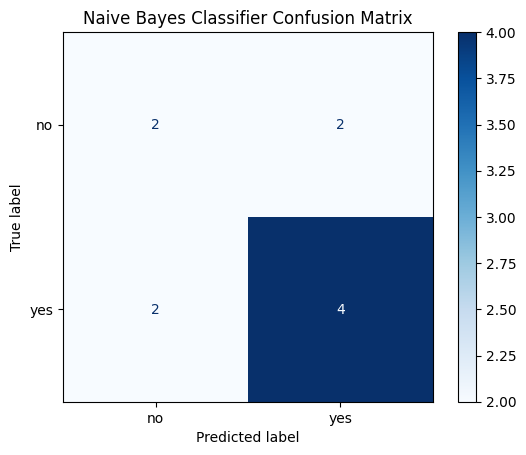

In [88]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kNN = NaiveBayessClassifier(laplace_smoothing=True, verbose = False)
kNN.fit(X, Y)

Y_pred = kNN.predict(X)
score = accuracy_score(Y, Y_pred)

print(f"Bayessian score : {score}")
mat = confusion_matrix(Y, Y_pred)
disp = ConfusionMatrixDisplay.from_predictions(
    y_true = Y, 
    y_pred = Y_pred,
    cmap=plt.cm.Blues,
    labels=kNN.y_categories
    )

disp.ax_.set_title(f"Naive Bayes Classifier Confusion Matrix")

plt.show()

# k-NN Classifier
The k-NN Classifier works by selecting k nearest neighbours by some metric (such as Euclides or Manhattan norm). Out of k closest neighbours we select the most common one or the closest one. This one is our final prediction.

Euclides Norm
$$
d_2(z, y) = (\sum_{i = 1}^n |z_i - y_i|^2)^{\frac{1}{2}}
$$
Manhattan Norm
$$
d_1(z, y) = \sum_{i = 1}^n|z_i - y_i|
$$

## Implementation

In [89]:
import sys
import operator

def Euclides_norm(X, Y):
    return np.sqrt(np.sum((X - Y)**2))

def Manhattan_norm(X, Y):
    return np.abs(np.sum(X - Y))

class kNN_classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_proximity_points = 3, norm = None, type="Simple", verbose = True):
        self.num_proximity_points = num_proximity_points

        if norm == "Euclides":
            self.norm = Euclides_norm
        elif norm == "Manhattan":
            self.norm = Manhattan_norm
        else:
            self.norm = Euclides_norm

        self.type = type
        self.verbose = verbose

    def fit(self, X, y):
        self.x = X
        self.y = Y

        self.y_categories = set()

        for x in y:
            self.y_categories.add(x)

        self.y_categories = list(self.y_categories)
        
        return self

    def predict(self, X_):
        results = np.array([*range(0, len(X_))], dtype=object)
        for i, X in X_.iterrows():
            norm_euc = self.x.apply(lambda row: self.norm(row, X.values.flatten()), axis=1)

            norm_euc = list(zip( list(norm_euc), [*range(0,10)], list(self.y)))
            if self.verbose:
                print(norm_euc)
            norm_euc.sort(key=lambda x: x[0])
        
            max_norm = max(norm_euc[:self.num_proximity_points], key=lambda x: x[0])[0]
            norm_euc = [s for s in norm_euc if s[0] <= max_norm]
            if self.verbose:
                print(norm_euc)

            if self.type == "Simple":
                weight = lambda x : 1.0
            elif self.type == "Weighted":
                weight = lambda x : 1.0 / ( x[0] + sys.float_info.epsilon )
            else:
                raise Exception(f"Invalid type '{self.type}'")
        
            d = {}
            for y_cat in self.y_categories:
                d[y_cat] = sum(weight(i) for i in norm_euc if i[2] == y_cat)
        
            val = max(d.items(), key=operator.itemgetter(1))[0]
            results[i] = val

        return results

## Training

In [90]:
def numeric(X):
    if X == 'none' or X == 'sunny' or X == 'cold' or X == 'no' : return 0
    if X == 'weak' or X == 'cloudy' or X == 'warm' or X == 'yes' : return 1
    return 2

X = training_obs[["Wind", "Weather", "Temperature"]]
X["Wind_numeric"] = training_obs["Wind"].transform(numeric)
X["Weather_numeric"] = training_obs["Weather"].transform(numeric)
X["Temperature_numeric"] = training_obs["Temperature"].transform(numeric)

X = X[["Wind_numeric", "Weather_numeric", "Temperature_numeric"]]
Y = training_obs["Played"]

pred_x = pd.DataFrame({
    "Wind" : [ "strong" ],
    "Weather" : [ "sunny" ],
    "Temperature" : [ "warm" ]
})

pred_x["Wind_numeric"]          = pred_x["Wind"].transform(numeric)
pred_x["Weather_numeric"]       = pred_x["Weather"].transform(numeric)
pred_x["Temperature_numeric"]   = pred_x["Temperature"].transform(numeric)
pred_x = pred_x[["Wind_numeric", "Weather_numeric", "Temperature_numeric"]]


kNN = kNN_classifier(norm="Manhattan", type="Weighted")
kNN.fit(X, Y)
dupa = kNN.predict(pred_x)
print(dupa)

[(0, 0, 'no'), (1, 1, 'no'), (2, 2, 'yes'), (1, 3, 'no'), (1, 4, 'yes'), (1, 5, 'yes'), (2, 6, 'no'), (1, 7, 'yes'), (0, 8, 'yes'), (1, 9, 'yes')]
[(0, 0, 'no'), (0, 8, 'yes'), (1, 1, 'no'), (1, 3, 'no'), (1, 4, 'yes'), (1, 5, 'yes'), (1, 7, 'yes'), (1, 9, 'yes')]
['yes']


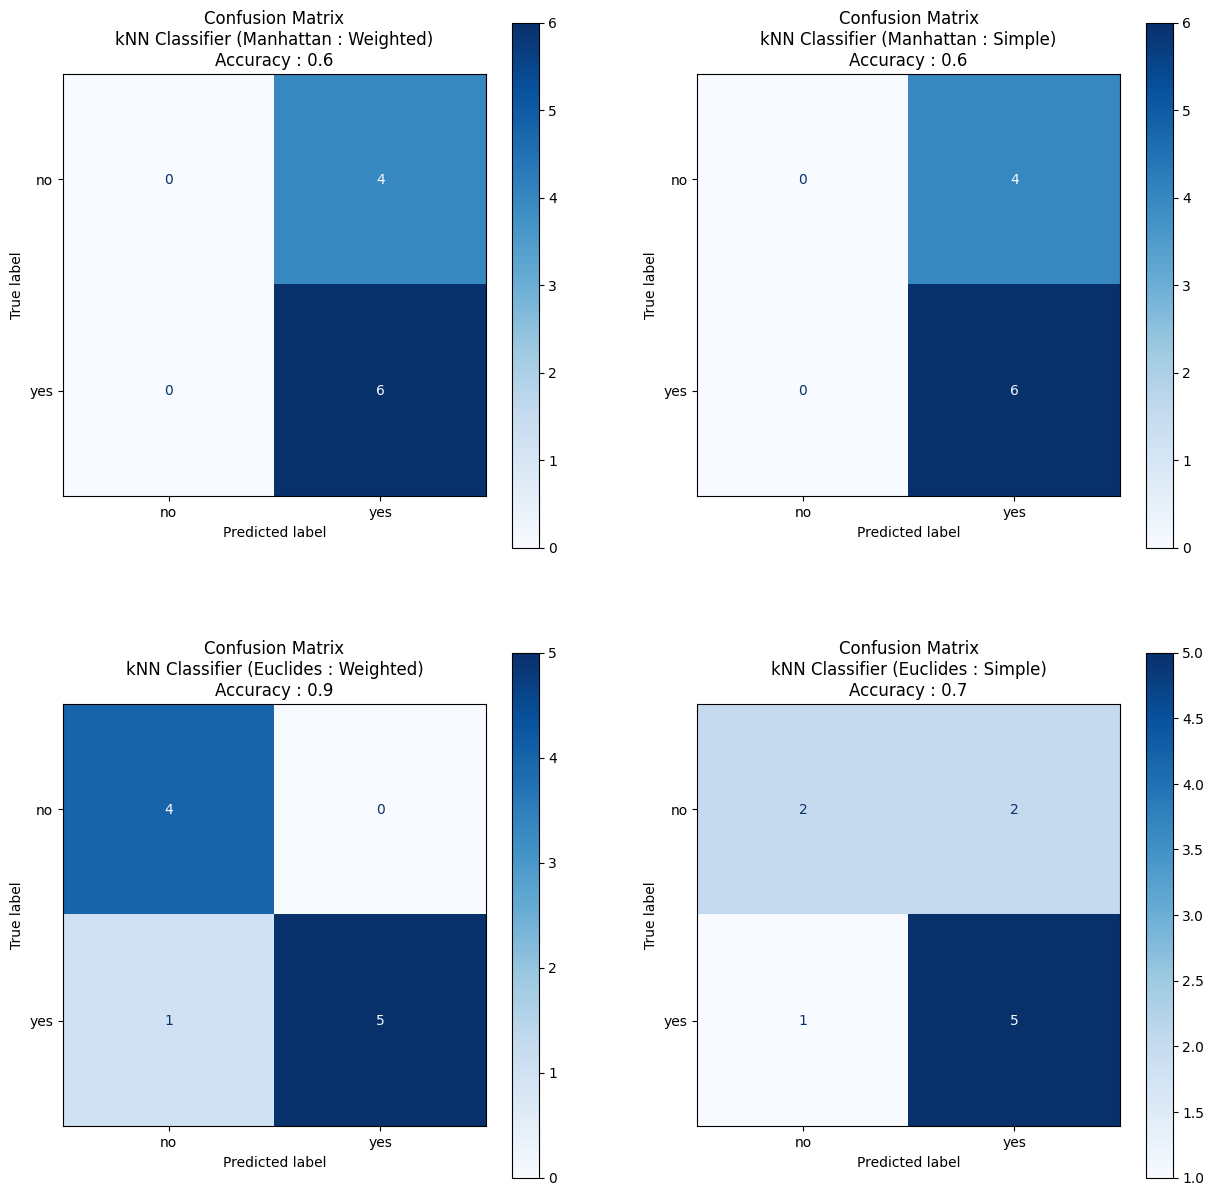

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
flat_axs = np.array(axs).flatten()

Y = training_obs["Played"]
i = 0
for norm in ["Manhattan", "Euclides"]:
    for type in ["Weighted", "Simple"]:
        kNN = kNN_classifier(norm=norm, type=type, verbose=False)
        kNN.fit(X, Y)
        Y_pred = kNN.predict(X)
        score = accuracy_score(Y, Y_pred)
        mat = confusion_matrix(Y, Y_pred)
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true = Y, 
            y_pred = Y_pred,
            cmap=plt.cm.Blues,
            labels=kNN.y_categories,
            ax=flat_axs[i]
        )
        i = i + 1
        disp.ax_.set_title(f"Confusion Matrix\nkNN Classifier ({norm} : {type})\nAccuracy : {score}")

plt.show()

# Visualizaiton

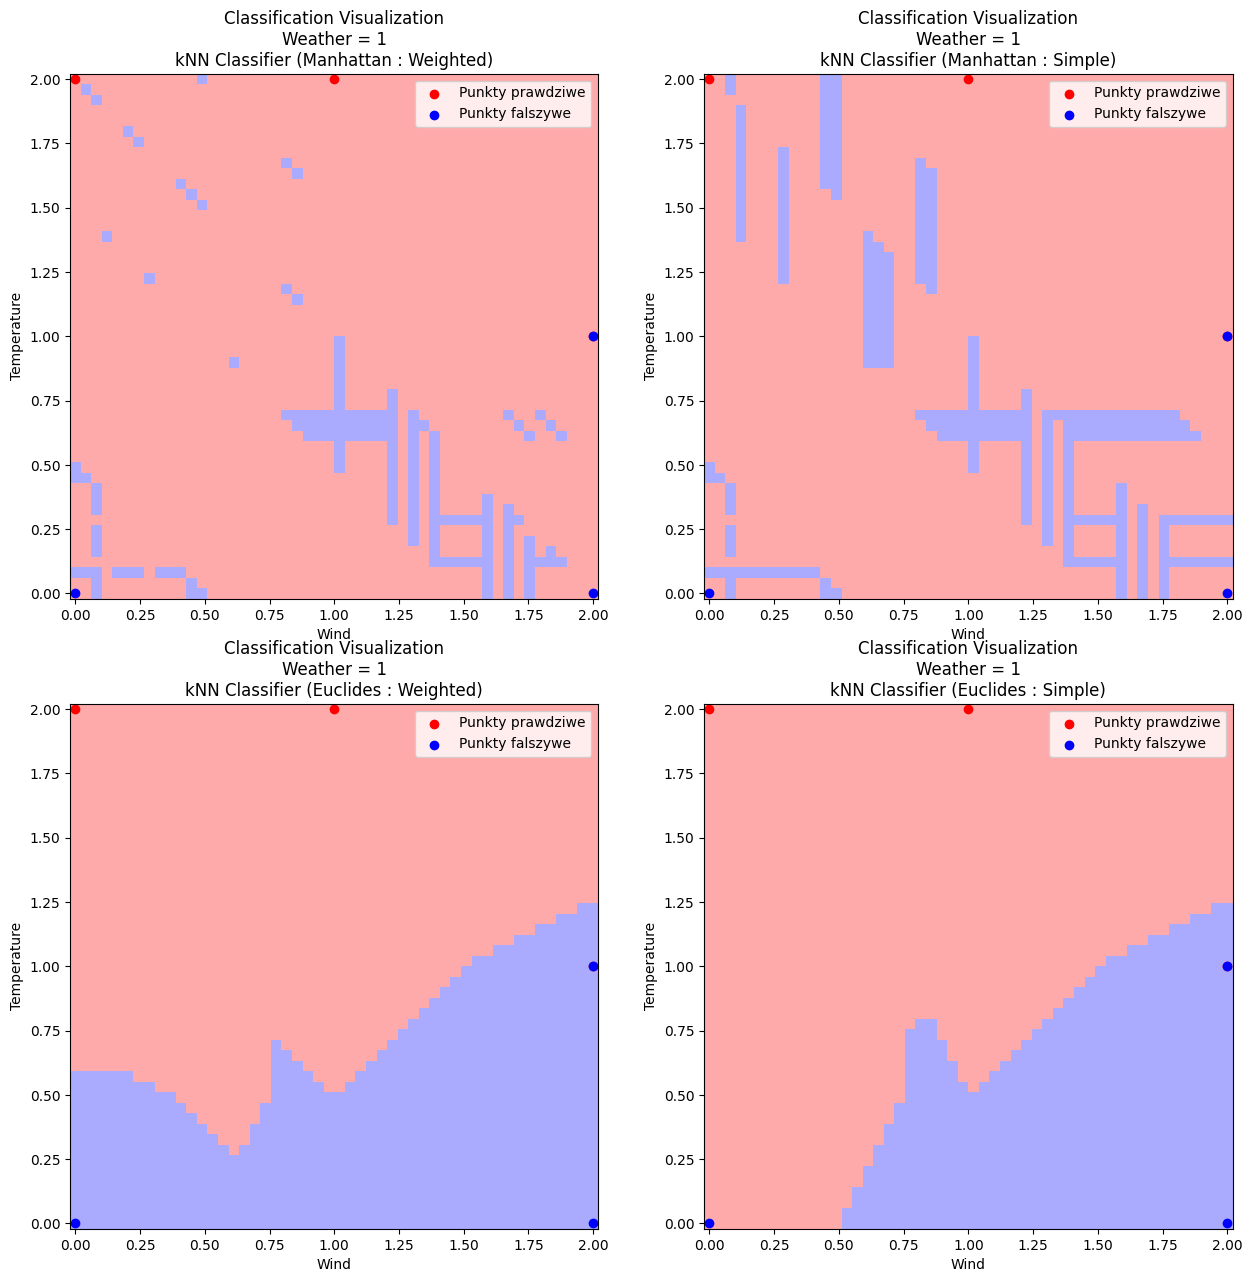

In [92]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

xx = list(np.linspace(0.0, 2.0, 50))
yy = list(np.linspace(0.0, 2.0, 50))

xx, yv = np.meshgrid(xx, yy)
xv = xx.reshape(1, -1)[0].copy()
yv = yv.reshape(1, -1)[0].copy()
ww = xv.copy()
ww = ww * 0.0 + 1.0
# print(xv)

cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
flat_axs = np.array(axs).flatten()
plot_i = 0

Y = training_obs["Played"]
for norm in ["Manhattan", "Euclides"]:
    for type in ["Weighted", "Simple"]:
        kNN = kNN_classifier(norm=norm, type=type, verbose=False)
        kNN.fit(X, Y)
        Y_pred = kNN.predict(X)
        mat = confusion_matrix(Y, Y_pred)
        x_pred = pd.DataFrame(
            {
                "Wind" : xv,
                "Weather" : ww,
                "Temperature" : yv
            }
        )

        Z = kNN.predict(x_pred)
        arr = np.array([*range(0, len(Z))])
        for i in range(0, len(Z)):
            arr[i] = numeric(Z[i])

        Z = arr.reshape(xx.shape).copy()

        X1_t_arr = np.array([])
        X1_t_arr.resize(len(Y), 1)
        X2_t_arr = np.array([])
        X2_t_arr.resize(len(Y), 1)
        X1_f_arr = np.array([])
        X1_f_arr.resize(len(Y), 1)
        X2_f_arr = np.array([])
        X2_f_arr.resize(len(Y), 1)
        Y_arr = np.array([])
        Y_arr.resize(len(Y), 1)

        count = 0
        for i in range(0, len(Y_arr)):
            if(X["Weather_numeric"][i] != ww[0] or Y[i] == "no"):
                continue
            X1_t_arr[count] = X["Wind_numeric"][i]
            X2_t_arr[count] = X["Temperature_numeric"][i]
            Y_arr[count] = numeric(Y[i])
            count += 1
        
        X1_t_arr.resize(count, 1)
        X2_t_arr.resize(count, 1)

        count = 0
        for i in range(0, len(Y_arr)):
            if(X["Weather_numeric"][i] != ww[0] or Y[i] == 'yes'):
                continue
            X1_f_arr[count] = X["Wind_numeric"][i]
            X2_f_arr[count] = X["Temperature_numeric"][i]
            Y_arr[count] = numeric(Y[i])
            count += 1

        X1_f_arr.resize(count, 1)
        X2_f_arr.resize(count, 1)

        ax = flat_axs[plot_i]
        plot_i = plot_i + 1
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        ax.scatter(X1_t_arr, X2_t_arr, color='r', label="Punkty prawdziwe")
        ax.scatter(X1_f_arr, X2_f_arr, color='b', label="Punkty falszywe")
        ax.set_xlabel("Wind")
        ax.set_ylabel("Temperature")
        ax.set_title(f"Classification Visualization\nWeather = 1\nkNN Classifier ({norm} : {type})")
        ax.legend()

plt.show()